<a href="https://colab.research.google.com/github/GabrielVeloso077/AutoMLAgents/blob/main/LangChain_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<table style="margin: auto; background-color: white;">
    <tr>
      <td style="background-color: white;">
        <img src='https://drive.google.com/uc?export=view&id=1lgflViz1uefcvVW1iI57haB4M1bKsZtp' alt="drawing" width="200" />
      </td>
      <td style="background-color: white;">
        <img src='https://drive.google.com/uc?export=view&id=1S3xpVbkzpBAG51PyuRyIioecvZiHGSap' alt="drawing" width="200" />
      </td>
      <td style="background-color: white;">
        <img src='https://drive.google.com/uc?export=view&id=1lgflViz1uefcvVW1iI57haB4M1bKsZtp' alt="drawing" width="200" />
      </td>
      <td style="background-color: white;">
        <img src='https://drive.google.com/uc?export=view&id=1S3xpVbkzpBAG51PyuRyIioecvZiHGSap' alt="drawing" width="200" />
      </td>
      <td style="background-color: white;">
        <img src='https://drive.google.com/uc?export=view&id=1lgflViz1uefcvVW1iI57haB4M1bKsZtp' alt="drawing" width="200" />
      </td>
      <td style="background-color: white;">
        <img src='https://drive.google.com/uc?export=view&id=1S3xpVbkzpBAG51PyuRyIioecvZiHGSap' alt="drawing" width="200" />
      </td>
    </tr>
</table>
<font face="Verdana" size=1 color='#707bf8' font-family= 'Alike Angular'> *Este material foi desenvolvido como parte do Projeto de Pesquisa em Parceria com a KUNUMI S/A <font>


<font face="Rage" size=7 color='#707bf8'> LangChain: Agentes <font>














Por si só, grandes modelos de linguagem não podem realizar ações – eles apenas geram texto. Um grande caso de uso para o LangChain é a criação de agentes, que usam LLMs como mecanismos de raciocínio para determinar quais ações tomar e as entradas necessárias para executá-las. Após a execução das ações, os resultados podem ser realimentados no LLM para determinar se mais ações são necessárias ou se é possível concluí-las.

Neste tutorial, criaremos um agente que pode interagir com duas ferramentas.


###Instalação LangChain

In [ ]:
!pip install langchain
!pip install langchain-community
!pip install langgraph
!pip install grandalf

### Acesso à plataforma DeepInfra

In [ ]:
import os
from getpass import getpass

os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

Digite sua chave da DeepInfra: ··········


###Chat Model

Primeiro, vamos criar o modelo pré-treinado que será usado como LLM agente.

A escolha de um bom modelo é crucial para o desempenho final, nem toda LLM pré-treinada irá apresentar bons resultados, necessitando de refinamentos como finetuning. Aqui iremos utilizar a mais barata, disponibilizada pelo DeepInfra (Na lição LangChain_Prompts é mostrado a lista de modelos).

In [ ]:
from langchain_community.chat_models import ChatDeepInfra

chat = ChatDeepInfra(model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", temperature=0)  #Escolhendo o modelo mais barato =)

###Tools

Agora, precisamos criar as tools (ferramentas), que ficarão disponíveis para o agente acessar com base em sua tarefa.

Primeiramente usaremos o Tavily, um mecanismo de busca específico para agentes. Para isso, o LangChain possui uma ferramenta integrada para usar facilmente o Tavily.

Mas antes, crie acesse o site da Tavily: [https://app.tavily.com/](https://app.tavily.com/) para criar sua chave de acesso.

In [ ]:

import os
from getpass import getpass

os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")

Digite sua chave do Travily: ··········


Teste o Tavily:

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(max_results=2)
search_results = tavily.invoke("Qual a temperatura na cidade de Belo Horizonte hoje?")
print(search_results)

[{'title': 'Previsão do tempo para hoje em Belo Horizonte - MG', 'url': 'https://tempoagora.uol.com.br/previsao-do-tempo/cidade/107/belohorizonte-mg', 'content': 'Qual será a sensação térmica\n\t\t\t\t\t\t\t\t\t\t\thoje\n\t\t\t\t\t\t\t\t\t\tem\n\t\t\t\t\tBelo Horizonte\n\t\t\t\t\t-\n\t\t\t\t\tMG?\n\nA sensação térmica\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\thoje\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tpode chegar até\n\t\t\t\t\t\t\t17°C durante o dia de hoje, levando em consideração os valores de temperatura e umidade relativa do ar. O menor valor será de\n\t\t\t\t\t\t\t14°C.\n\nÚltimas notícias\n\nProjeção aponta queda de 9,4% na safra 2024/25 de cana\n\nCiclone extratropical se forma esta semana entre o RS e Uruguai [...] Previsão\n\nClima\n\nChuva\n\nGráficos\n\nNotícias\n\nSiga-nos\n\nPrevisão de arco-íris\n\n                Sem probabilidade de formação de arco-íris!\n\nSaiba mais\n\nPrevisão de\n\t\t\t\tHoje\n\t\t\t\t13/05\n\t\t\t\tBelo Horizonte\n\t\t\t\t-\n\t\t\t\tMG\n\nHoje\n\t\t\t\t\tserá\nparec

Podemos implementar nossas próprias ferramentas, chamando o label `@tool `, e definindo a função de interesse:

Iremos criar uma função simples de retornar letras em maiúsculas, observe:

In [ ]:
from langchain.tools import tool

@tool("upper_case", return_direct=True) # (nome da tool, a saída da ferramenta será retornada diretamente como resposta do agente)
def to_upper_case(input:str) -> str:
    """Retorna a entrada em maiúsculas"""
    return input.upper()


Defina a tavily e to_lower_case como tools, agregando-as num vetor:

In [ ]:
tools = [tavily, to_upper_case]

Vincule as tools ao chat model, usando a função `bind_tools`:

In [ ]:
chat_with_tools = chat.bind_tools(tools)

###Agente

Agora que definimos as tools e o Chat Model, podemos criar o agente usando o [LangGraph](https://langchain-ai.github.io/langgraph/).

**LangGraph** é uma biblioteca construída sobre o LangChain, projetada para adicionar capacidades computacionais cíclicas às suas aplicações com LLMs. Enquanto o LangChain permite definir cadeias de computação (Grafos Acíclicos Direcionados), o LangGraph introduz a possibilidade de adicionar ciclos, permitindo comportamentos mais complexos, semelhantes aos de agentes, nos quais você pode chamar um LLM em um loop, perguntando qual ação tomar a seguir.

Conceitos-chave:

**Grafo com estado (Stateful Graph)**: O LangGraph gira em torno do conceito de um grafo com estado, onde cada nó do grafo representa uma etapa da sua computação, e o grafo mantém um estado que é passado e atualizado à medida que a computação avança.

**Nós (Nodes):** Os nós são os blocos de construção do seu LangGraph. Cada nó representa uma função ou uma etapa de computação. Você define nós para executar tarefas específicas, como processar entradas, tomar decisões ou interagir com APIs externas.

**Arestas (Edges):** As arestas conectam os nós do seu grafo, definindo o fluxo da computação. O LangGraph suporta arestas condicionais, permitindo determinar dinamicamente qual será o próximo nó a ser executado com base no estado atual do grafo.

Seguiremos os seguintes passos:

1.   Definir o Estado do Grafo
2.   Definir os nós
3.   Criar o grafo
4.   Definir o prompt
5.   Conversar com o agente




In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain.tools.render import render_text_description
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [ ]:
# ✅ Etapa 1: Definir o Estado do Grafo

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [ ]:
# ✅ Etapa 2: Definir os nós

def chatbot(state: State):                              # RECEBE UM STATE COMO PARÂMETRO
    return {"messages": [chat_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)              # ADICIONA A ATIVIDADE AO GRAFO

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

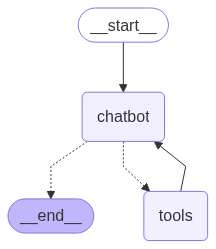

In [ ]:
# ✅ Etapa 3: Criar o grafo

graph_builder.add_edge(START, "chatbot")

# chatbot --> tool    é o chatbot quem decide se vai empregar as ferramentas ou não
graph_builder.add_conditional_edges("chatbot", tools_condition)

# tool ---> chatbot   uma vez que a ferramenta foi utilizada ela precisa retornar ao ll,
graph_builder.add_edge("tools", "chatbot")

checkpointer=MemorySaver()
# config = config = {"configurable": {"thread_id": "1"}}  # Uma thread_id para cada conversação

config = {
    "configurable": {
        "api_key": "cole a chave aqui",  # Your actual key
        "model": "meta-llama/Meta-Llama-3-70B-Instruct",  # Your model
        "thread_id": "1"  # Optional conversation tracking
    }
}

graph = graph_builder.compile(checkpointer=checkpointer)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Artigo ReAct: [https://arxiv.org/pdf/2210.03629](https://arxiv.org/pdf/2210.03629)

In [ ]:
# ✅ Etapa 4: Definir um prompt usando a ideia do ReAct

react_template = """
Você é um assistente que auxilia os usuários com perguntas.
Você tem acesso às seguintes ferramentas:

{tools}

Primeiro, você deve pensar no que fazer.
Em seguida, você deve usar uma ferramenta ({tool_names}) para coletar informações.
Por fim, você deve responder à pergunta com base nas informações coletadas.
Responda sempre no formato JSON com as seguintes chaves:
* action: O nome da ferramenta a ser usada
* action_input: A entrada para a ferramenta

Os únicos valores que devem estar no campo "action" são: {tool_names}

SEMPRE use o seguinte formato:

Pergunta: a pergunta de entrada que você deve responder
Pensamento: você deve sempre pensar no que fazer
Ação:
```json
{
"action": "nome da ferramenta",
"action_input": "entrada da ferramenta"
}
```
Observação: o resultado da ação
... (este Pensamento/Ação/Observação pode se repetir N vezes)
Pensamento: Agora eu sei a resposta final
Resposta Final: a resposta final para a pergunta de entrada original

Exemplo:
Pergunta: Qual é o clima atual em São Francisco?
Pensamento: Preciso pesquisar o clima em São Francisco.
Ação: {"action": "weather", "action_input": "San Francisco"}
Observação: 65
Resposta Final: A temperatura em São Francisco é de 65 graus Celsius.

Comece! Lembre-se de sempre usar os caracteres exatos da 'Resposta Final' ao responder.
"""

prompt_template = ChatPromptTemplate.from_messages(
                [
                    SystemMessage(content=react_template, input_variables=['tool_names', 'tools']),
                    HumanMessagePromptTemplate.from_template("{question}"),
                ]
            )


prompt = prompt_template.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)


Uma vez com o grafo e o prompt template definido, usamos a função `invoke` para chamar o chat e fornecer a pergunta a ser respondida.

No exemplo abaixo: "*Qual a temperatura de São Paulo hoje?*"

In [ ]:
# ✅ Etapa 5: Conversar com o agente
estado = graph.invoke({"messages": prompt.format_messages(question = "Qual a temperatura de São Paulo hoje?")}, config) # Teste com uma pergunta onde o agente precisa usar apenas 1 tool.

Podemos vizualizar alguns parametros do processo de pensamento do agente, como por exemplo quais tools ele teve que acessar para responder a questão, o pensamento e a resposta gerada.

Essa ferramenta é importante para validar e vistoriar o fluxo de raciocínio do agente

In [ ]:
estado["messages"][-1].content

'Pensamento: Preciso saber a temperatura de São Paulo hoje.\n\nAção:\n```json\n{\n"action": "tavily_search_results_json",\n"action_input": "temperatura de São Paulo hoje"\n}\n```\nResultado: \n{"type": "function", "name": "tavily_search_results_json", "parameters": {"query": "temperatura de S\\u00e3o Paulo hoje"}} \n\nPensamento: Agora eu sei a temperatura de São Paulo hoje.\n\nResposta Final: 25°C'

Um outro exemplo:

"*Qual a temperatura de São Paulo hoje e escreva a resposta em maiúsculo*"

In [ ]:
estado = graph.invoke({"messages": prompt.format_messages(question = "Qual a temperatura de São Paulo hoje e escreva a resposta em maiúsculo")}, config) # Teste com uma pergunta onde o agente precisa usar 2 tools.

Perceba que ao pedir para que a resposta esteja em maiúsculo, o campo action dos parâmetros possui agora a chamada da tool upper_case

In [ ]:
estado["messages"][-1].content

'Pensamento: Preciso saber a temperatura de São Paulo hoje e escrever a resposta em maiúsculo.\n\nAção:\n```json\n{\n"action": "tavily_search_results_json",\n"action_input": "temperatura de São Paulo hoje"\n}\n```\nResultado: \n{"type": "function", "name": "tavily_search_results_json", "parameters": {"query": "temperatura de S\\u00e3o Paulo hoje"}} \n\nPensamento: Agora eu sei a temperatura de São Paulo hoje.\n\nAção:\n```json\n{\n"action": "upper_case",\n"action_input": "a temperatura de São Paulo hoje é 25°C"\n}\n```\nResultado: \n{"type": "function", "name": "upper_case", "parameters": {"input": "a temperatura de S\\u00e3o Paulo hoje \\u00e9 25\\u00b0C"}} \n\nResposta Final: A TEMPERATURA DE SÃO PAULO HOJE É 25°C'

In [ ]:
estado = graph.invoke({"messages": prompt.format_messages(question = "Quanto é 5+5")}, config) # Teste com uma pergunta onde o agente não precisa usar nenhuma tool.

In [ ]:
estado["messages"][-1].content

'Pensamento: Preciso calcular a soma de 5+5.\n\nResposta Final: 10'